In [2]:
# 引入这个项目需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # 使得我们可以对DataFrame使用display()函数
import xgboost as xgb
from time import time
from sklearn.model_selection import train_test_split
import gc
import operator
import matplotlib

In [3]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

In [4]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [ ]:
data_all_features=pd.read_csv('data_all_final_features_0522.csv')
store_features=pd.read_csv('store_final_features_0522.csv')

In [ ]:
data_store_all=pd.merge(data_all_features,store_features,left_on='Store',right_on='Store',how='left')

In [6]:
#依照Sales字段是否为空分割为train和test
#去掉train中的Id字段
train_all=data_store_all[data_store_all['Sales'].notnull()]
train_all=train_all.drop(columns=['Id'])

#只保留train中Open字段为1的数据
train_all=train_all[train_all['Open']==1]


test_all=data_store_all[data_store_all['Sales'].isnull()].reset_index(drop=True)
test_id=test_all['Id']
test_all=test_all.drop(columns=['Id'])

In [7]:
features_all=data_store_all.columns.tolist()

In [8]:
features_all.remove('Sales')


In [9]:
features_all.remove('Id')

In [27]:
for i in features_all:
    print(i)

Day
Month
Open
Promo
SchoolHoliday
Store
Week
Year
CompetitionDistance
Promo2
DeltaPromo2Weeks
IsPromo2Month
AbsDeltaCompetition
BeforeCompetition
AfterCompetition
StateHolidayNextMonth
StateHolidayLastMonth
SchoolHolidayNextMonth
SchoolHolidayLastMonth
StateHolidayThisMonth
SchoolHolidayThisMonth
StateHolidayThisWeek
StateHolidayNextWeek
StateHolidayLastWeek
SchoolHolidayThisWeek
SchoolHolidayNextWeek
SchoolHolidayLastWeek
AssortmentEncoding
DayOfWeek_1
DayOfWeek_2
DayOfWeek_3
DayOfWeek_4
DayOfWeek_5
DayOfWeek_6
DayOfWeek_7
StateHoliday_0
StateHoliday_a
StateHoliday_b
StateHoliday_c
StoreType_a
StoreType_b
StoreType_c
StoreType_d
PromoInterval_Feb,May,Aug,Nov
PromoInterval_Jan,Apr,Jul,Oct
PromoInterval_Mar,Jun,Sept,Dec
AvgSales
AvgCustomers
AvgSalesPerCustomer
AvgSales_Stype
AvgCustomers_Stype
AvgSales_Interval
AvgCustomers_Interval
AvgSales_Asslev
AvgCustomers_Asslev
AvgSales_Promo2
AvgCustomers_Promo2
ST_Sales_Dev
ST_Customers_Dev
Asslev_Sales_Dev
Asslev_Customers_Dev
Promo2_Sales_D

In [10]:
del data_store_all
gc.collect()

21

In [11]:
#训练集中最后7周最为验证集,其余作为新的训练集
val_all=train_all[(train_all['Week']>22) & (train_all['Week']<=30) & (train_all['Year']==2015)]

In [12]:
train_new_all = train_all[~train_all.index.isin(val_all.index)]

In [13]:
val_all=val_all.reset_index(drop=True)
train_new_all=train_new_all.reset_index(drop=True)

In [14]:
del train_all
gc.collect()

7

建立xgboost模型

In [15]:
params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": 0.01,
          "max_depth": 12,
          "min_child_weight": 6,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1,
          #"lambda": 0.1,
          "seed": 523}




In [17]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(train_new_all[features_all], np.log(train_new_all["Sales"] + 1))
dvalid = xgb.DMatrix(val_all[features_all], np.log(val_all["Sales"] + 1))
dtest = xgb.DMatrix(test_all[features_all])
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
gbm = xgb.train(params, dtrain,num_boost_round = 15000, evals=watchlist, early_stopping_rounds=200, feval=rmspe_xg, verbose_eval=50)




Train a XGBoost model
[0]	train-rmse:8.1852	eval-rmse:8.19839	train-rmspe:0.999864	eval-rmspe:0.999867
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 200 rounds.
[50]	train-rmse:4.9548	eval-rmse:4.97896	train-rmspe:0.992728	eval-rmspe:0.992939
[100]	train-rmse:3.00093	eval-rmse:3.03333	train-rmspe:0.948798	eval-rmspe:0.950564
[150]	train-rmse:1.81971	eval-rmse:1.85643	train-rmspe:0.834856	eval-rmspe:0.840659
[200]	train-rmse:1.10658	eval-rmse:1.14409	train-rmspe:0.665933	eval-rmspe:0.676266
[250]	train-rmse:0.677327	eval-rmse:0.713888	train-rmspe:0.491022	eval-rmspe:0.503425
[300]	train-rmse:0.420759	eval-rmse:0.456985	train-rmspe:0.348016	eval-rmspe:0.359354
[350]	train-rmse:0.269803	eval-rmse:0.305271	train-rmspe:0.249766	eval-rmspe:0.256205
[400]	train-rmse:0.1839	eval-rmse:0.218838	train-rmspe:0.190518	eval-rmspe:0.191467
[450]	train-rmse:0.137913	eval-rmse:0.171623	train-rmspe:0.158848	eval-rmsp

In [ ]:
print("Validating")
yhat = gbm.predict(xgb.DMatrix(X_valid[features_all]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

In [18]:
print("Make predictions on the test set")
test_probs = gbm.predict(dtest)
indices = test_probs < 0
test_probs[indices] = 0


Make predictions on the test set


In [19]:
test_id_int=[int(i) for i in test_id]
submission = pd.DataFrame({"Id": test_id_int, "Sales": np.exp(test_probs) - 1})
submission.to_csv("submission_full_para_2.csv", index=False)

In [28]:
#画出feature importance曲线
create_feature_map(features_all)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()



Text(0.5, 0, 'relative importance')

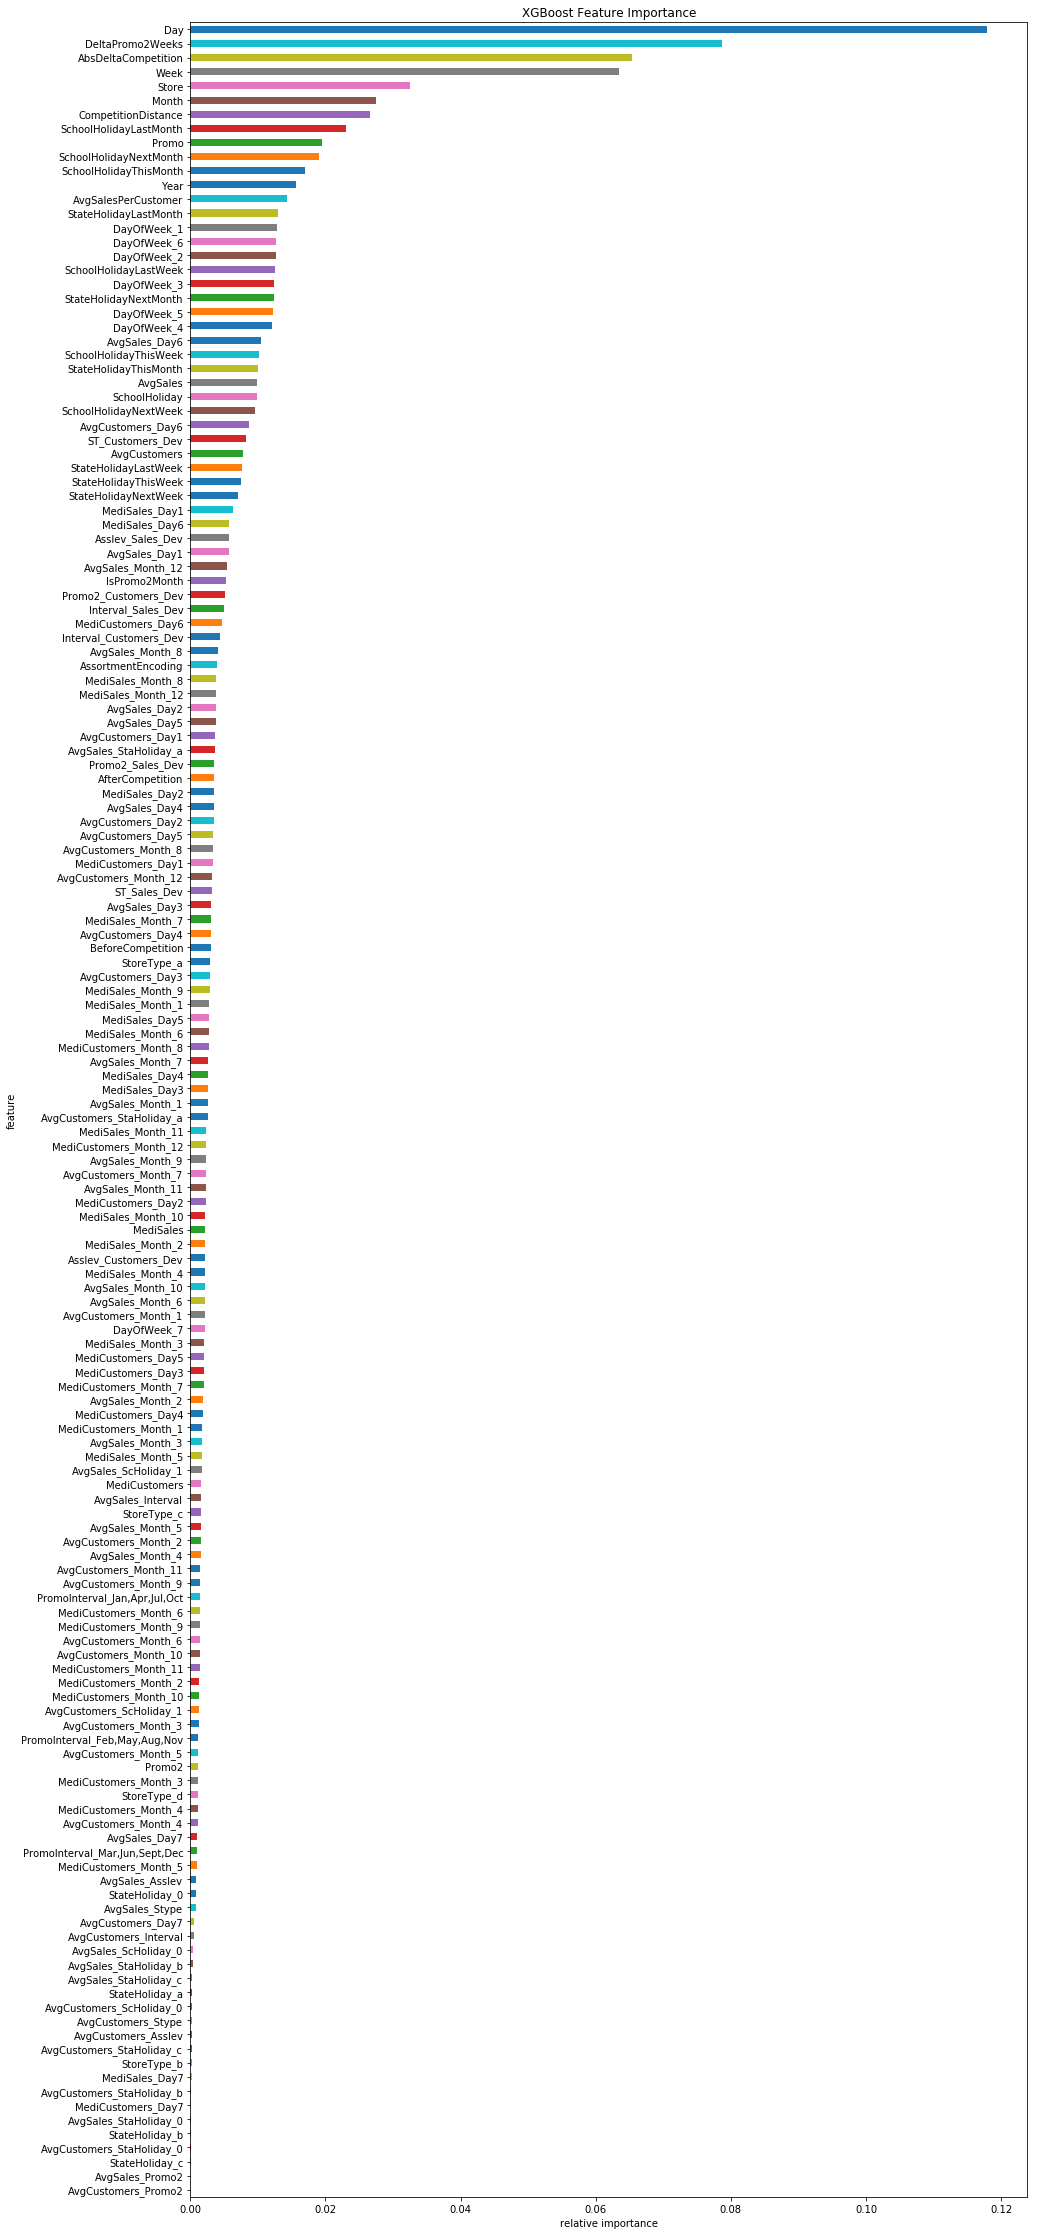

In [29]:
featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(15, 40))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [45]:
df=df.sort_values(by=['fscore'],ascending=False)

In [49]:
df=df.reset_index(drop=True)
df['cum_fscore']=df['fscore'].cumsum()